In [1]:
import qubx

%qubxd

%load_ext autoreload
%autoreload 2

from typing import cast
import numpy as np
import pandas as pd
import asyncio
from pathlib import Path
from qubx.core.lookups import lookup
from qubx.connectors.ccxt.factory import get_ccxt_exchange
from qubx import logger, QubxLogConfig
from qubx.core.interfaces import IStrategy, IStrategyContext, BaseErrorEvent, IStrategyInitializer
from qubx.utils.runner.runner import run_strategy, StrategyConfig, AccountConfigurationManager, ExchangeConfig, LoggingConfig
from qubx.utils.runner.configs import LiveConfig, ReaderConfig
from qubx.core.basics import DataType, MarketEvent
from qubx.utils.charting.lookinglass import LookingGlass

QubxLogConfig.set_log_level("INFO")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.93
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


## 1.0 Define simple strategy that does nothing

Just subscribes to OHLC[1h], orderbook aggregated in 0.01% buckets top 100 levels (1% depth).

In [2]:
class TestStrategy(IStrategy):

    def on_init(self, initializer: IStrategyInitializer):
        initializer.set_base_subscription(DataType.TRADE)
        initializer.set_subscription_warmup({
            DataType.OHLC["1h"]: "1d"
        })
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        pass

    def on_error(self, ctx: IStrategyContext, error: BaseErrorEvent) -> None:
        logger.error(f"Error: {error}")

    def on_stop(self, ctx: IStrategyContext):
        logger.info("Stopping test strategy")

In [3]:
ctx = run_strategy(
    config=StrategyConfig(
        name="TestStrategy",
        strategy=TestStrategy,
        aux=ReaderConfig(reader="xlighter", args={"max_history": "10d"}),
        live=LiveConfig(
            exchanges={
                "LIGHTER": ExchangeConfig(
                    connector="xlighter",
                    universe=["BTCUSDC", "ETHUSDC"],
                )
            },
            logging=LoggingConfig(
                logger="InMemoryLogsWriter",
                position_interval="10s",
                portfolio_interval="1m",
                heartbeat_interval="10m",
            )
        )
    ),
    account_manager=AccountConfigurationManager(search_qubx_dir=True),
    paper=True,
    blocking=False,
)

2025-10-20 17:39:04.340 [ℹ️] Initialized LighterClient (testnet=False, account_index=225671, api_key_index=2)
2025-10-20 17:39:04.342 [ℹ️] Loading instruments from Lighter API...
2025-10-20 17:39:09.054 [ℹ️] Found 94 markets
2025-10-20 17:39:09.055 [ℹ️] Successfully loaded 94 instruments
2025-10-20 17:39:09.056 [ℹ️] LighterDataProvider initialized
2025-10-20 17:39:09.058 [ℹ️] Loading instruments from Lighter API...
2025-10-20 17:39:09.345 [ℹ️] Found 94 markets
2025-10-20 17:39:09.346 [ℹ️] Successfully loaded 94 instruments
2025-10-20 17:39:09.346 [ℹ️] XLighterDataReader initialized: 94 instruments loaded, max_history=10d
2025-10-20 17:39:09.347 [ℹ️] - Strategy: TestStrategy
- Mode: paper
- Parameters: {}
2025-10-20 17:39:09.353 [ℹ️] Starting warmup for 2 configurations
2025-10-20 17:39:09.659 [ℹ️] OHLC warmup for ETHUSDC: loaded 24 1h bars
2025-10-20 17:39:09.944 [ℹ️] OHLC warmup for BTCUSDC: loaded 24 1h bars
2025-10-20 17:39:09.945 [ℹ️] Warmup complete
2025-10-20 17:39:11.055 [ℹ️] Co

2025-10-20 17:39:11.456 [ℹ️] Waiting for all instruments (0/2 ready). Missing: ['ETHUSDC', 'BTCUSDC']. Will start with partial data in 60s
2025-10-20 17:39:11.457 [ℹ️] Heartbeat at 2025-10-20T17:30:00
2025-10-20 17:39:12.129 [ℹ️] All 2 instruments have data - strategy ready to start
2025-10-20 17:40:00.065 [ℹ️] Heartbeat at 2025-10-20T17:40:00
2025-10-20 17:40:00.475 [ℹ️] Fetched 1502 funding payment records for 2 symbols
2025-10-20 17:40:53.826 [ℹ️] Stopping test strategy
2025-10-20 17:40:53.829 [ℹ️] Disconnecting from WebSocket
2025-10-20 17:40:54.097 [ℹ️] Disconnected from WebSocket
2025-10-20 17:40:54.098 [ℹ️] LighterDataProvider closed
2025-10-20 17:40:54.100 [ℹ️] [StrategyContext] :: Market data processing stopped


In [4]:
ctx.subscribe(DataType.ORDERBOOK[0.01, 10])

In [5]:
add_symbols = ["BTCUSDC", "ETHUSDC", "XRPUSDC", "SOLUSDC", "DOGEUSDC", "ADAUSDC", "LINKUSDC", "XPLUSDC", "HYPEUSDC"]
add_instruments = [ctx.query_instrument(symbol) for symbol in add_symbols]
print(add_instruments)
ctx.set_universe(add_instruments)

[LIGHTER:SWAP:BTCUSDC, LIGHTER:SWAP:ETHUSDC, LIGHTER:SWAP:XRPUSDC, LIGHTER:SWAP:SOLUSDC, LIGHTER:SWAP:DOGEUSDC, LIGHTER:SWAP:ADAUSDC, LIGHTER:SWAP:LINKUSDC, LIGHTER:SWAP:XPLUSDC, LIGHTER:SWAP:HYPEUSDC]


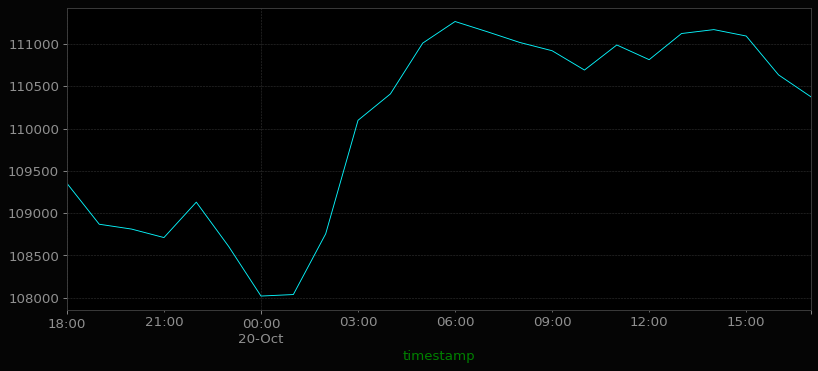

In [6]:
ctx.ohlc(ctx.query_instrument("BTCUSDC"), "1h").pd()["close"].plot();

In [7]:
ctx.quote(ctx.query_instrument("XPLUSDC"))

[2025-10-20T17:27:41.068000000]	0.39752 (27460.80) | 0.39779 (110569.10)

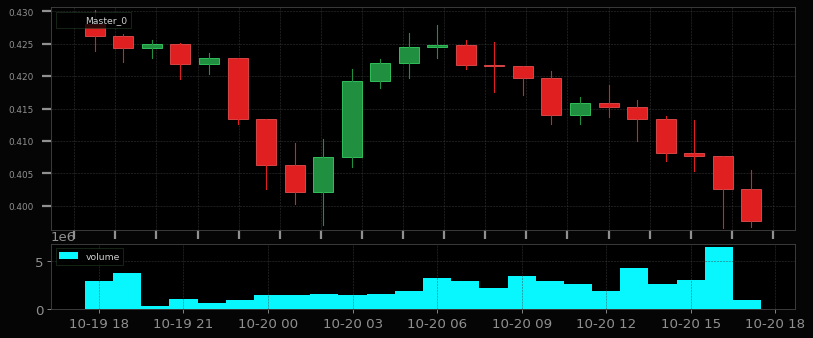

In [8]:
ohlc = ctx.ohlc(ctx.query_instrument("XPLUSDC"), "1h").pd()

LookingGlass(
    ohlc,
    {
        "volume": ["bars", ohlc["volume"]],
    },
    backend="mpl",
).look()

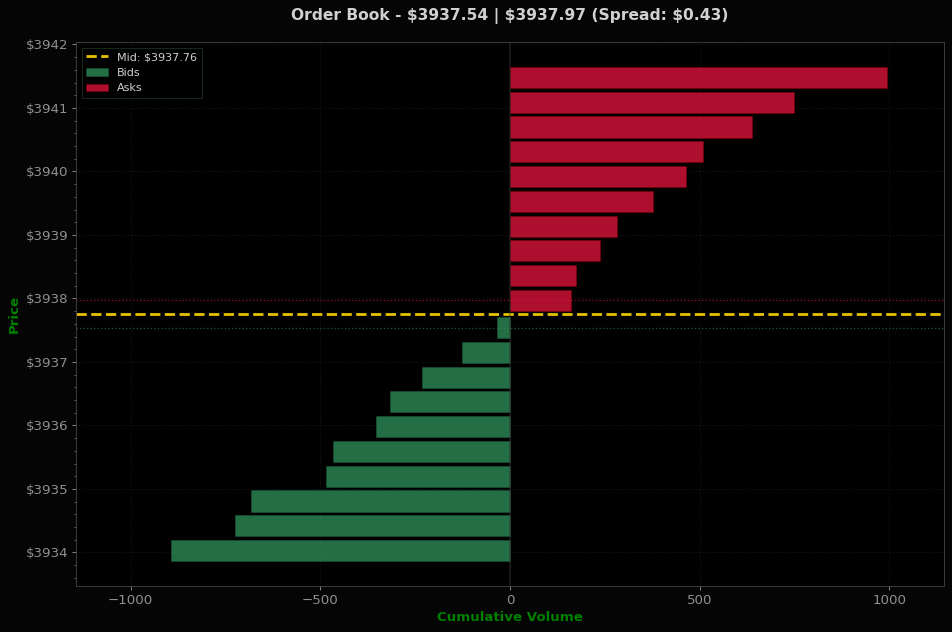

In [10]:
from qubx.utils.charting.orderbook import plot_orderbook

plot_orderbook(
    (ob:=ctx.get_data(ctx.query_instrument("ETHUSDC"), DataType.ORDERBOOK)[-1]),
    cumulative=True
);

## 2.0 Test aux data

In [4]:
from qubx.data.readers import AsPandasFrame

data = cast(pd.DataFrame, ctx.get_aux_data(
    "funding_payment",
    exchange="LIGHTER",
    symbols=["BTCUSDC", "ETHUSDC"],
    start="2025-10-15",
))

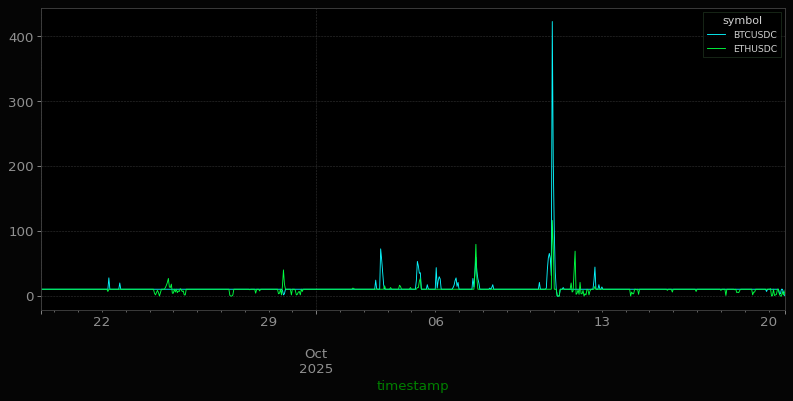

In [ ]:
data["funding_rate_apr"] = data["funding_rate"] / data["funding_interval_hours"] * 24 * 365 * 100
data["funding_rate_apr"].unstack(1).plot();

In [6]:
ctx.stop()